# Analysis of Clustering Model

This is an analysis of the patterns that
occure in our audio files.

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np

BLACKLIST = set([
    235, 104, 33, 252, 542, 236, 193, 254, 452, 
    453, 40, 66, 340, 476, 1005, 1017, 1033, 1034, 1035,
    1038, 1047, 105, 109, 11, 122, 124, 135, 142, 155, 157, 1570,
    177, 1788, 179, 1904, 193, 194, 195, 1966, 197, 203, 2126,
    227, 235, 236, 243, 252, 254, 264, 2666, 293, 296, 325, 33,
    331, 332, 345, 354, 359, 363, 364, 3665, 373, 399, 4182, 424,
    44, 443, 450, 452, 453, 455, 460, 465, 476, 487, 495, 5, 503, 504,
    521, 53, 530, 542, 583, 588, 6, 620, 647, 66, 660, 71, 719, 74, 
    747, 75, 80, 806, 82, 821, 903, 918, 963, 972, 976, 978, 979, 
    985, 989, 99, 98, 637, 904
    ])

In [ ]:
sys.path.append('..')

In [2]:
MODEL = "v2_lstm_v5"
PATH  = "../models/{}".format(MODEL)

## Prepare Base Statistics

+ Compute the distance between signals in time
+ Compute the annotations for each file
+ Assign cluster series

In [292]:
n_clusters = {}
diffs      = {}
annotation = {}
for filename in os.listdir(PATH):
    if filename.startswith('behavior_'):
        path = "{}/{}".format(PATH, filename) 
        key  = filename.split('.')[0]
        df = pd.read_csv(path).head()
        df = df[~df["cluster"].isin(BLACKLIST)]
        if len(df) > 0:
            annotation[key] = df['behavior'][df.index[0]]            
            df = df.sort_values('start')
            df_last = df.shift(1)
            diff = df['start'] - df_last['stop']
            diff = list(diff.dropna())
            diffs[key] = diff
            n_clusters[key] = list([row['cluster'] for _, row in df.iterrows()])

In [293]:
n_per_session_distinct = [len(set(v)) for v in n_clusters.values()]
n_per_session          = [len(v) for v in n_clusters.values()]

num_clusters  = sum(n_per_session)
num_sessions  = len(n_clusters)
print("#sessions: {}".format(num_sessions))
print("#clusters: {}".format(num_clusters))

#sessions: 47
#clusters: 195


## Detections

Check the amount of signals we can detect in each session

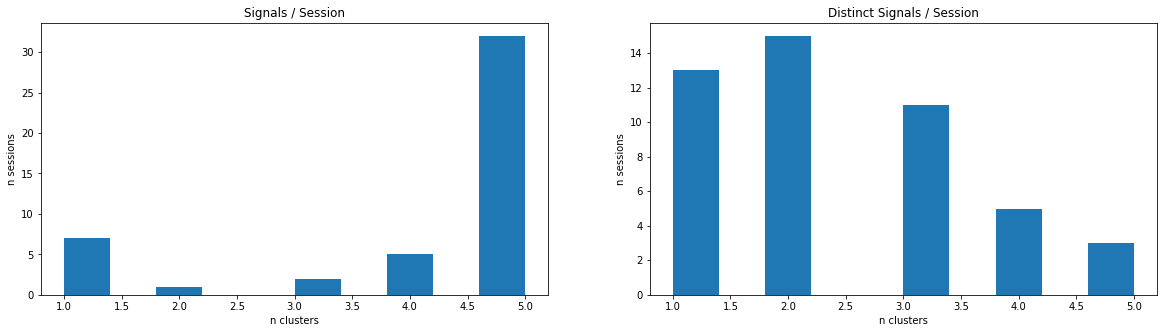

In [294]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(n_per_session)
plt.title('Signals / Session')
plt.xlabel("n clusters")
plt.ylabel("n sessions")
plt.subplot(1, 2, 2)
plt.hist(n_per_session_distinct)
plt.title('Distinct Signals / Session')
plt.xlabel("n clusters")
plt.ylabel("n sessions")
plt.show()

## Activity Profiles

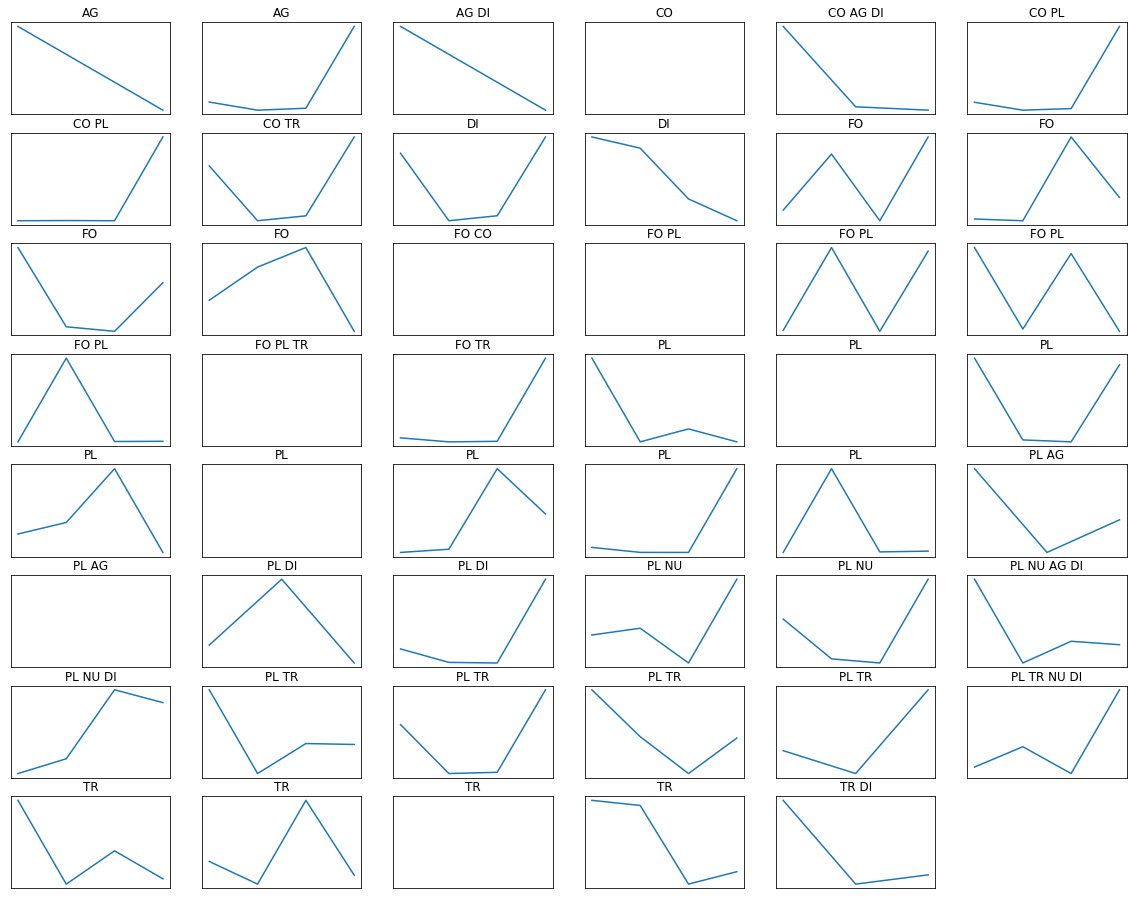

In [295]:
items = []
for k, v in diffs.items():
    items.append((annotation[k], v))
items = sorted(items, key=lambda x: x[0])

plt.figure(figsize = (20, 20))
for i, diff in enumerate(items):
    k, diff = diff
    plt.subplot(10, 6, i + 1)
    plt.title(k)
    plt.yticks([])
    plt.xticks([])
    plt.plot(diff)
plt.show()

In [296]:
fr = 44000
differences = {}
for k, v in items:
    tokens = k.split(' ')
    for t in tokens:
        for d in v:
            if t not in differences:
                differences[t] = []
            else:            
                differences[t].append(d)
diff = sorted([(k, np.mean(v) / 44000) for k, v in differences.items()], key=lambda x: x[1])

## Signal Frequency

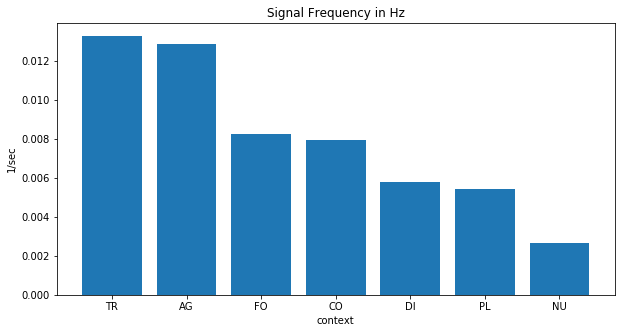

In [297]:
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(diff)), [1.0 / v for _, v in diff])
plt.title('Signal Frequency in Hz')
plt.xticks(np.arange(len(diff)), [t for t, _ in diff])
plt.xlabel('context')
plt.ylabel('1/sec')
plt.show()

## Cluster Usage

In [298]:
clusters = {}
for k, v in n_clusters.items():
    for c in v:
        if c in clusters:
            clusters[c] += 1
        else:
            clusters[c]  = 1
clusters = sorted([(c, count) for c, count in clusters.items()], key=lambda x: -x[1])

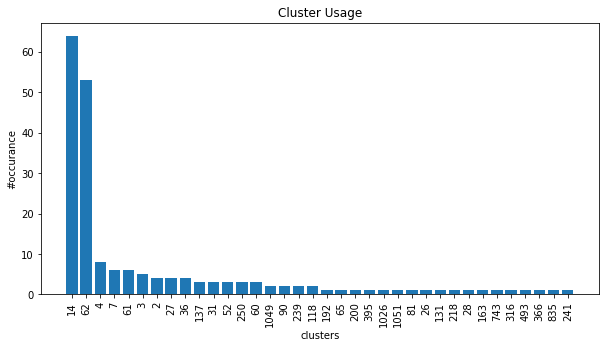

In [299]:
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(clusters)), [c for i, c in clusters])
plt.title('Cluster Usage')
plt.xticks(np.arange(len(clusters)), [str(i) for i, c in clusters], rotation=90)
plt.xlabel("clusters")
plt.ylabel("#occurance")
plt.show()

## Cluster Usage By Context

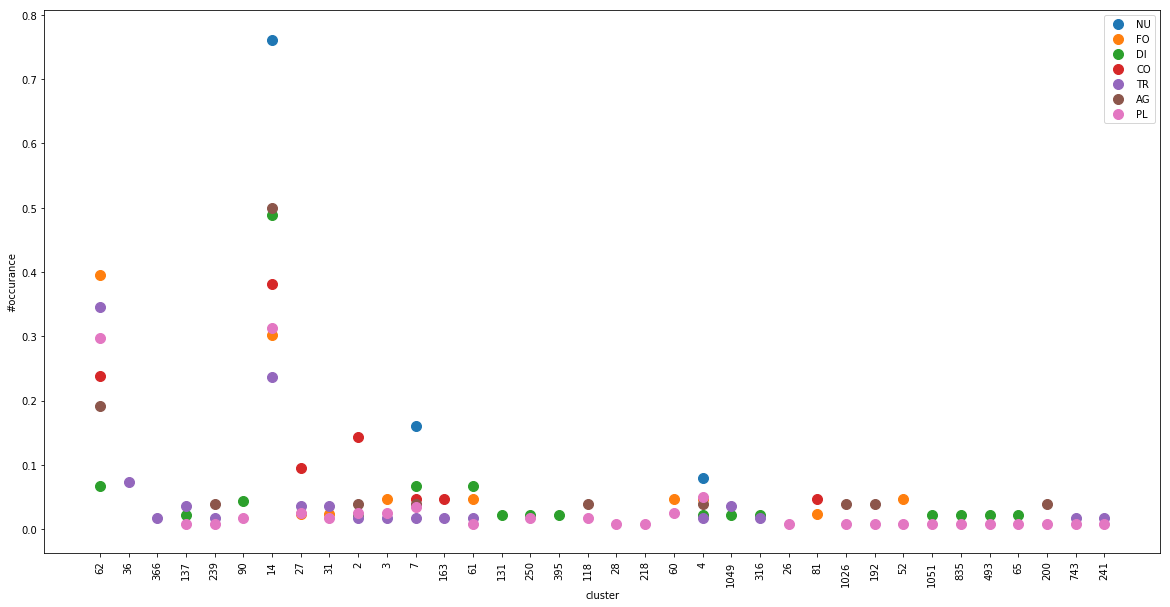

In [300]:
clusters = {}
ids = {}
cur = 0
for k, v in n_clusters.items():
    for t in annotation[k].split(' '):
        if t not in clusters:
            clusters[t] = {}
        for c in v:
            if c not in ids:
                ids[c] = cur
                cur += 1
            if c in clusters[t]:
                clusters[t][c] += 1
            else:
                clusters[t][c]  = 1
plt.figure(figsize=(20, 10))
for c, v in clusters.items():
    scaler = np.sum([c for i, c in v.items()])
    x = [(ids[i], c / scaler) for i, c in v.items()]
    x = sorted(x, key=lambda x: x[0])
    plt.scatter([i for i, c in x], [c for i, c in x],s=100, label=c)
plt.xticks(np.arange(0, len(ids)), [str(i) for i, _ in sorted([(i, ids[i]) for i, c in ids.items()], key=lambda x: x[1])], rotation=90)
plt.ylabel("#occurance")
plt.xlabel("cluster")
plt.legend()
plt.show()